# Covid-19 Data for India

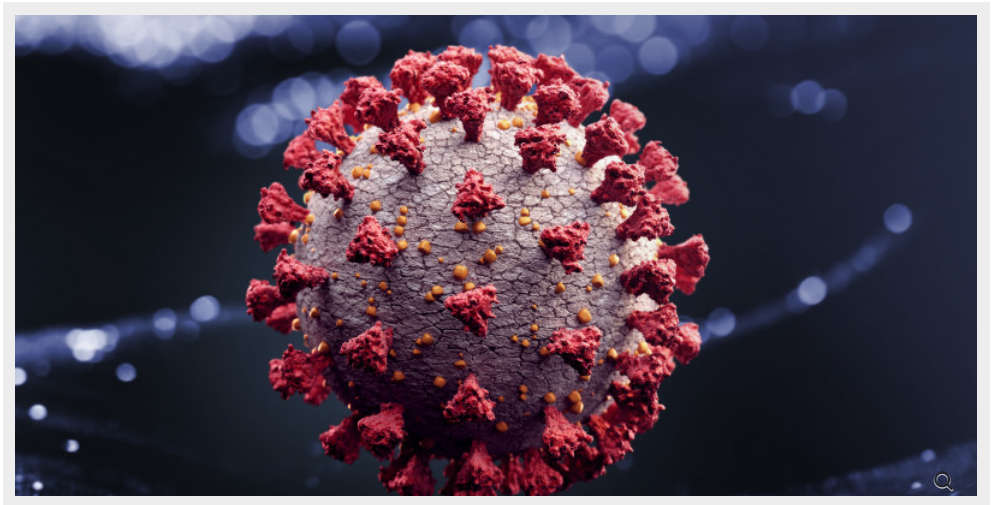

# Importing Libraries

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'plotly'

# Importing Data

In [2]:
# Loading dataset
df_ind = pd.read_csv("covid_19_india.csv")
df_ind

Sno        Date     Time State/UnionTerritory  \
0          1  2020-01-30  6:00 PM               Kerala   
1          2  2020-01-31  6:00 PM               Kerala   
2          3  2020-02-01  6:00 PM               Kerala   
3          4  2020-02-02  6:00 PM               Kerala   
4          5  2020-02-03  6:00 PM               Kerala   
...      ...         ...      ...                  ...   
15801  15802  2021-06-08  8:00 AM            Telangana   
15802  15803  2021-06-08  8:00 AM              Tripura   
15803  15804  2021-06-08  8:00 AM          Uttarakhand   
15804  15805  2021-06-08  8:00 AM        Uttar Pradesh   
15805  15806  2021-06-08  8:00 AM          West Bengal   

      ConfirmedIndianNational ConfirmedForeignNational    Cured  Deaths  \
0                           1                        0        0       0   
1                           1                        0        0       0   
2                           2                        0        0       0   
3                           3                        0        0       0   
4                           3                        0        0       0   
...                       ...                      ...      ...     ...   
15801                       -                        -   564303    3394   
15802                       -                        -    49579     572   
15803                       -                        -   313566    6731   
15804                       -                        -  1662069   21333   
15805                       -                        -  1388771   16362   

       Confirmed  
0              1  
1              1  
2              2  
3              3  
4              3  
...          ...  
15801     593103  
15802      56169  
15803     334419  
15804    1699083  
15805    1432019  

[15806 rows x 9 columns]

### Solve Ambiguity in Names of States

In [3]:
# List of states to see the incorrect data
states = sorted(df_ind['State/UnionTerritory'].unique().tolist())
states

['Andaman and Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Cases being reassigned to states',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra and Nagar Haveli',
 'Dadra and Nagar Haveli and Daman and Diu',
 'Daman & Diu',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu and Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Telengana',
 'Tripura',
 'Unassigned',
 'Uttar Pradesh',
 'Uttarakhand',
 'West Bengal']

In [4]:
# as we can see that their is lot of ambuiguity in names of states to sove the problem we will replace the names as follows
replace_dict = {'Cases being reassigned to states': 'other',
                'Dadra and Nagar Haveli' : 'Dadra and Nagar Haveli and Daman and Diu',
                'Daman & Diu' : 'Dadra and Nagar Haveli and Daman and Diu',
                'Telengana' : 'Telangana',
                'Unassigned': 'other'
               }

# replacing the states name with given values
df_ind['State/UnionTerritory'] = df_ind['State/UnionTerritory'].replace(replace_dict)

### Finding the Active Cases, Recovery Rate

In [5]:
# finding active cases
df_ind['Active'] = df_ind['Confirmed']-df_ind['Deaths']-df_ind['Cured']

# finding recovery rate
df_ind["Recovery_Rate"] = df_ind['Cured']/df_ind['Confirmed']*100

### Drop unnecessary columns

In [6]:
# dropunnecessary columns
df_ind = df_ind.drop(['Time', 'Sno', 'ConfirmedIndianNational', 'ConfirmedForeignNational'], axis=1)

df_ind

Date State/UnionTerritory    Cured  Deaths  Confirmed  Active  \
0      2020-01-30               Kerala        0       0          1       1   
1      2020-01-31               Kerala        0       0          1       1   
2      2020-02-01               Kerala        0       0          2       2   
3      2020-02-02               Kerala        0       0          3       3   
4      2020-02-03               Kerala        0       0          3       3   
...           ...                  ...      ...     ...        ...     ...   
15801  2021-06-08            Telangana   564303    3394     593103   25406   
15802  2021-06-08              Tripura    49579     572      56169    6018   
15803  2021-06-08          Uttarakhand   313566    6731     334419   14122   
15804  2021-06-08        Uttar Pradesh  1662069   21333    1699083   15681   
15805  2021-06-08          West Bengal  1388771   16362    1432019   26886   

       Recovery_Rate  
0           0.000000  
1           0.000000  
2           0.000000  
3           0.000000  
4           0.000000  
...              ...  
15801      95.144182  
15802      88.267550  
15803      93.764409  
15804      97.821531  
15805      96.979928  

[15806 rows x 7 columns]

# Updating the daily cases 
#### As we can see, their is data of total cases till the perticular date, and their is no data present for new cases found on that day so, we find out the data of each day as below - 

1. First we take data for each state separately in loop
2. For each state we find out New_Confirmed, New_Deaths, New_Cured, New_Active, Recovery columns for each state dataframe - 
   1. As we have Total cases for each day we can find out New cases by substracting previous day from current day
   2. We Update every column in the same way except New_Active column 
   3. New Active, Recovery Columns finded by Mathematical formulae
   
3. Append the Dataframe of perticular state into list
4. Concatenate all the dataframes of states into single Dataframe
5. Sort Dataframe by Date and Fill NaN values with 0
6. New Updated dataframe is Ready !!!

In [7]:
states = df_ind['State/UnionTerritory'].unique().tolist()

states_df_list = []

for state in states:
    df =  df_ind.loc[df_ind['State/UnionTerritory']==state]

    confirmed = df['Confirmed'].tolist()
    deaths    = df['Deaths'].tolist()
    cured     = df['Cured'].tolist()

    # new confirmed cases by substracting previous day records from current record

    # daily confirmed
    new_confirmed = [confirmed[0]]
    new_deaths = [deaths[0]]
    new_cured = [cured[0]]

    new1 = confirmed[0]
    new2 = deaths[0] 
    new3 = cured[0] 
    
    for i in range(1, len(confirmed)):
        
        # daily confirmed cases
        if (confirmed[i] - confirmed[i-1])>=0:
            new1 = confirmed[i] - confirmed[i-1] 
            
        new_confirmed.append(new1)
        
         # daily deaths
        if (deaths[i] - deaths[i-1])>=0:
            new2 = deaths[i] - deaths[i-1] 
            
        new_deaths.append(new2)
        
        # daily cured
        if (cured[i] - cured[i-1])>=0:
            new3 = cured[i] - cured[i-1] 
            
        new_cured.append(new3)
    
   
    
    # adding new columns to data
    
    df["New_Confirmed"] = new_confirmed
    df["New_Deaths"]= new_deaths
    df["New_Cured"] = new_cured

    
    # Appending data of current state into list of dataframes which is holding dataframes of each state
    states_df_list.append(df)
    
    
# Forming final dataframe by concatenating the all the dataframes from list of dataframes
# sorting the dataframe by Dates and replacing NaN values with 0

cov_df = pd.concat(states_df_list)

# sort data by date
cov_df = cov_df.sort_values(['Date', 'State/UnionTerritory'])

# fill NaN values
cov_df = cov_df.fillna(0)

cov_df.head(50)

Date State/UnionTerritory  Cured  Deaths  Confirmed  Active  \
0   2020-01-30               Kerala      0       0          1       1   
1   2020-01-31               Kerala      0       0          1       1   
2   2020-02-01               Kerala      0       0          2       2   
3   2020-02-02               Kerala      0       0          3       3   
4   2020-02-03               Kerala      0       0          3       3   
5   2020-02-04               Kerala      0       0          3       3   
6   2020-02-05               Kerala      0       0          3       3   
7   2020-02-06               Kerala      0       0          3       3   
8   2020-02-07               Kerala      0       0          3       3   
9   2020-02-08               Kerala      0       0          3       3   
10  2020-02-09               Kerala      0       0          3       3   
11  2020-02-10               Kerala      0       0          3       3   
12  2020-02-11               Kerala      0       0          3       3   
13  2020-02-12               Kerala      0       0          3       3   
14  2020-02-13               Kerala      0       0          3       3   
15  2020-02-14               Kerala      0       0          3       3   
16  2020-02-15               Kerala      0       0          3       3   
17  2020-02-16               Kerala      0       0          3       3   
18  2020-02-17               Kerala      0       0          3       3   
19  2020-02-18               Kerala      0       0          3       3   
20  2020-02-19               Kerala      0       0          3       3   
21  2020-02-20               Kerala      0       0          3       3   
22  2020-02-21               Kerala      0       0          3       3   
23  2020-02-22               Kerala      0       0          3       3   
24  2020-02-23               Kerala      0       0          3       3   
25  2020-02-24               Kerala      0       0          3       3   
26  2020-02-25               Kerala      0       0          3       3   
27  2020-02-26               Kerala      0       0          3       3   
28  2020-02-27               Kerala      0       0          3       3   
29  2020-02-28               Kerala      0       0          3       3   
30  2020-02-29               Kerala      0       0          3       3   
31  2020-03-01               Kerala      0       0          3       3   
34  2020-03-02                Delhi      0       0          1       1   
33  2020-03-02               Kerala      0       0          3       3   
32  2020-03-02            Telangana      0       0          1       1   
38  2020-03-03                Delhi      0       0          1       1   
37  2020-03-03               Kerala      3       0          3       0   
36  2020-03-03            Rajasthan      0       0          1       1   
35  2020-03-03            Telangana      0       0          1       1   
42  2020-03-04                Delhi      0       0          1       1   
41  2020-03-04              Haryana      0       0          2       2   
40  2020-03-04               Kerala      3       0          3       0   
44  2020-03-04            Rajasthan      0       0         15      15   
43  2020-03-04            Telangana      0       0          1       1   
39  2020-03-04        Uttar Pradesh      0       0          6       6   
45  2020-03-05                Delhi      0       0          2       2   
46  2020-03-05              Haryana      0       0          2       2   
47  2020-03-05               Kerala      3       0          3       0   
48  2020-03-05            Rajasthan      0       0         15      15   
49  2020-03-05            Telangana      0       0          1       1   

    Recovery_Rate  New_Confirmed  New_Deaths  New_Cured  
0             0.0              1           0          0  
1             0.0              0           0          0  
2             0.0              1           0          0  
3             0.0              1           0          

# India's Datewise Coronavirus data from Feb-2020 to June-2021

In [8]:
df_datewise = cov_df.groupby('Date').sum()
df_datewise

Cured  Deaths  Confirmed   Active  Recovery_Rate  \
Date                                                              
2020-01-30         0       0          1        1       0.000000   
2020-01-31         0       0          1        1       0.000000   
2020-02-01         0       0          2        2       0.000000   
2020-02-02         0       0          3        3       0.000000   
2020-02-03         0       0          3        3       0.000000   
...              ...     ...        ...      ...            ...   
2021-06-04  26597655  340702   28574350  1635993    3259.261092   
2021-06-05  26795549  344082   28694879  1555248    3274.152379   
2021-06-06  26984781  346759   28809339  1477799    3286.348544   
2021-06-07  27159180  349186   28909975  1401609    3300.504824   
2021-06-08  27341462  351309   28996473  1303702    3315.366922   

            New_Confirmed  New_Deaths  New_Cured  
Date                                              
2020-01-30              1           0          0  
2020-01-31              0           0          0  
2020-02-01              1           0          0  
2020-02-02              1           0          0  
2020-02-03              0           0          0  
...                   ...         ...        ...  
2021-06-04         132364        2713     207071  
2021-06-05         120529        3380     197894  
2021-06-06         114460        2677     189232  
2021-06-07         100636        2427     174399  
2021-06-08          86498        2123     182282  

[496 rows x 8 columns]

## 1. Overview of Coronavirus

In [9]:
overview = cov_df.groupby('Date')['Confirmed','Active','Deaths','Cured'].sum()
overview

Confirmed   Active  Deaths     Cured
Date                                            
2020-01-30          1        1       0         0
2020-01-31          1        1       0         0
2020-02-01          2        2       0         0
2020-02-02          3        3       0         0
2020-02-03          3        3       0         0
...               ...      ...     ...       ...
2021-06-04   28574350  1635993  340702  26597655
2021-06-05   28694879  1555248  344082  26795549
2021-06-06   28809339  1477799  346759  26984781
2021-06-07   28909975  1401609  349186  27159180
2021-06-08   28996473  1303702  351309  27341462

[496 rows x 4 columns]

In [10]:
# finding the last entry in table
last = overview.iloc[-1,1:4]
last

Active     1303702
Deaths      351309
Cured     27341462
Name: 2021-06-08, dtype: int64

In [11]:
# overview data
overview_ = overview.iloc[-1,0:4]

# figure for table
fig = go.Figure(data=[go.Table(
    
  header=dict(values=['<b>Categories</b>','<b>Cases</b>']),

  cells=dict(values=[overview_.index, overview_.values])
    
)])

# layout of table
fig.update_layout(
    title='India COVID-19 Scenario on June-2021',
)
fig.show()



# labels for pie chart
labels = ["Active", "Death", "Cured"]

# pie chart 
fig = px.pie(overview, 
             values = last, 
             names  = labels, 
             hole   = 0.7,
             title = "Total Confirmed Cases So Far - "+str( overview.iloc[-1,0])
            )

# layout of pie chart
fig.update_traces(textposition='outside', 
                  textinfo='percent+label')
fig.show()

# 2. Trends with Daily New Cases
## 2.1 Daily New Confirmed Cases 

In [12]:
# plotting line chart for daily new confirmed cases
fig = px.line(df_datewise, 
              x = df_datewise.index, 
              y = 'New_Confirmed',
              hover_data = ["New_Confirmed", df_datewise.index],
              title = "Daily New Confirmed Cases (Feb-2020  to  Jun-2021)",
              labels = {"New_Confirmed":"Daily New Confirmed Cases  in (K)",
                        "Date" : "Date", 
                       },
              )
fig.show()

## 2.2 Daily New Deaths

In [13]:
# plotting line chart for daily new deaths
fig = px.line(df_datewise, 
              x = df_datewise.index, 
              y = 'New_Deaths',
              hover_data = ["New_Deaths", df_datewise.index],
              title = "Daily New Deaths (Feb-2020  to  Jun-2021)",
              labels = {"New_Deaths":"Daily New Deaths",
                        "Date" : "Date", 
                       }
              )

fig.show()

## 2.3 Daily New Recoveries

In [14]:
# plotting line chart for daily Recoveries
fig = px.line(df_datewise, 
              x = df_datewise.index, 
              y = 'New_Cured',
              hover_data = ["New_Cured", df_datewise.index],
              title = "Daily New Recoveries (Feb-2020  to  Jun-2021)",
              labels = {"New_Cured":"Daily New Recoveries in (k)",
                        "Date" : "Date", 
                       }
              )
fig.update_traces(line_color='rgb(0,200,0)')
fig.show()

## 2.4 Daily New Confirmed Cases, Deaths and Recoveries 

In [15]:
# plotting all three plots altogether 
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_datewise.index, y=df_datewise.New_Confirmed,
                    mode='lines',
                    name='Daily New Confirmed Cases'))
fig.add_trace(go.Scatter(x=df_datewise.index, y=df_datewise.New_Deaths,
                    mode='lines',
                    name='Daily Deaths'))
fig.add_trace(go.Scatter(x=df_datewise.index, y=df_datewise.New_Cured,
                    mode='lines',
                    name='Daily Recoveries'))

fig.update_layout(title='Daily New Cases, Deaths and Recoveries by CoronaVirus',
                  xaxis_title="Date",
                  yaxis_title="New Cases",
                  yaxis_zeroline=False, 
                  xaxis_zeroline=False)

fig.show()

# 3. Trends with Total Cases
## 3.1 Daily Total Confirmed Cases

In [16]:
# plotting line chart for daily total confirmed cases
fig = px.line(df_datewise, 
              x = df_datewise.index, 
              y = 'Confirmed',
              hover_data = ["Confirmed", df_datewise.index],
              title = "Daily Total Confirmed Cases (Feb-2020  to  Jun-2021)",
              labels = {"Confirmed":"Daily Total Confirmed Cases  in (M)",
                        "Date" : "Date", 
                       },
              )
fig.show()

## 3.2 Daily Total Deaths

In [17]:
# plotting line chart for daily total deaths
fig = px.line(df_datewise, 
              x = df_datewise.index, 
              y = 'Deaths',
              hover_data = ["Deaths", df_datewise.index],
              title = "Daily Total Deaths (Feb-2020  to  Jun-2021)",
              labels = {"Deaths":"Daily Total Deaths",
                        "Date" : "Date", 
                       }
              )
fig.update_traces(line_color='rgb(250,0,0)')
fig.show()

## 3.3 Daily Total Recoveries

In [18]:
# plotting line chart for daily total Recoveries
fig = px.line(df_datewise, 
              x = df_datewise.index, 
              y = 'Cured',
              hover_data = ["Cured", df_datewise.index],
              title = "Daily Total Recoveries (Feb-2020  to  Jun-2021)",
              labels = {"Cured":"Daily Total Recoveries",
                        "Date" : "Date", 
                       }
              )
fig.update_traces(line_color='rgb(0,200,0)')
fig.show()

## 3.4 Daily Total Confirmed Cases, Deaths and Recoveries

In [19]:
# plotting all three plots altogether 
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_datewise.index, y=df_datewise.Confirmed,
                    mode='lines',
                    name='Daily Total Confirmed Cases'))
fig.add_trace(go.Scatter(x=df_datewise.index, y=df_datewise.Deaths,
                    mode='lines',
                    name='Daily Total Deaths'))
fig.add_trace(go.Scatter(x=df_datewise.index, y=df_datewise.Cured,
                    mode='lines',
                    name='Daily Total Recoveries'))

fig.update_layout(title='Daily Total Confirmed Cases, Deaths and Recoveries by CoronaVirus',
                  xaxis_title="Dates",
                  yaxis_title="Daily Total",
                  yaxis_zeroline=False, 
                  xaxis_zeroline=False)

fig.show()

# 4. Recovery Rate 

In [20]:
# plotting line chart for recovery rate
fig = px.line(df_datewise, 
              x = df_datewise.index, 
              y = 'Recovery_Rate',
              hover_data = ["Recovery_Rate", df_datewise.index],
              title = "Daily Total Recoveries (Feb-2020  to  Jun-2021)",
              labels = {"Recovery_Rate":"Percentage of Recovered Patients",
                        "Date" : "Date", 
                       }
              )
fig.update_traces(line_color='rgb(0,200,0)')
fig.show()

As we can see recovery rate was very low at initial phase but goes on increasing, this may be the result of getting awareness and availing proper medical treatments, again we see the decrease in the month of May-2021 when Corona was at its peek, so not getting proper medicines due to sudden increase in patients causes lowering the recovery rate.

# 5. Stateswise Data  

## 5.1 Statewise Data in Table Format

In [21]:
state_wise = cov_df.groupby(['State/UnionTerritory'])['Confirmed','Cured' ,'Deaths', 'Active'].max().sort_values('Confirmed', ascending=False)
state_wise['Recovery_Rate'] =  state_wise['Cured']/state_wise['Confirmed']*100
fig = go.Figure(data=[go.Table(
  
  header=dict(
    values=['<b>State/Union Territory</b>','<b>Total Confirmed Cases </b>', '<b>Recoveries</b>', '<b>Deaths</b>','<b>Active</b>', '<b>Recovery Rate</b>'],
  ),
    
  cells=dict(
    values=[state_wise.index,
            state_wise.Confirmed, 
            state_wise.Cured, 
            state_wise.Deaths, 
            state_wise.Active,
            state_wise.Recovery_Rate
           ],
  )
    
)])
fig.update_layout(
    title='Statewise COVID-19 Scenario',
)
fig.show()

## 5.2 Statewise Data in Bar Chart

In [22]:
# bar chart for statewise coronavirus data for total recoveries, active cases and deaths

fig = go.Figure()

# adding bars for Recoveries
fig.add_trace(go.Bar(x = state_wise['Cured'],
                     y = state_wise.index,
                     name ='Recovered Cases',
                     orientation ='h',
                     text = state_wise['Cured'], 
                    )
             )

# adding bars for active 
fig.add_trace(go.Bar(x = state_wise['Active'],
                     y = state_wise.index,
                     name ='Active Cases',
                     orientation ='h',
                     text = state_wise['Active'], 
                     marker=dict(
                         color='rgb(255, 150, 0)',)
                     )
             )

# adding bars for deaths
fig.add_trace(go.Bar(x = state_wise['Deaths'],
                     y = state_wise.index,
                     name='Death Cases',
                     orientation='h',
                     text = state_wise['Deaths'], 
                     marker=dict(
                         color='rgb(255, 0, 0)',)
                     )
             )

# defining layouts with-
#'stack' as bar styles
# titles, xaxis, yaxis
# height and width of chart
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

fig.update_layout(barmode ='stack', 
                  title = "Statewise COVID-19 Scenario on June-2021",
                  xaxis = {"title":"Cases in (M)"},
                  yaxis = {'categoryorder':'total ascending', 
                           "title":"States/Union Territory"},
                  
                  width=1500,
                  height=1500,
                  )
fig.show()

In [23]:
# function to plot statewise data of given features 
def plot_statewise_barchart(df, targets):
    for target in targets:
        fig = go.Figure()

        colors = ['rgb(104,108,252)'] * len(df.index)
        colors[0] = 'crimson'
        # adding bars for Recoveries
        fig.add_trace(go.Bar(x = df[target],
                             y = df.index,
                             name ='Recovered Cases',
                             orientation ='h',
                             marker_color = colors,
                             text = df[target]
                            )
                    )



        # defining layouts with-
        # titles, xaxis, yaxis
        # height and width of chart
        
        # using label dict for giving proper titles according to feature
        labels = {'Confirmed'    :"Statewise Total Confirmed Cases",
                  'Deaths'       :"Statewise Total Deaths",
                  'Cured'        :"Statewise Total Recoveries"}
        
        current_title = labels[target]
        
        # for annotations
        fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
        
        # for layout
        fig.update_layout(
                  title = current_title, 
                  titlefont_size = 20,
                  xaxis = {"title":"Cases in (M)"},
                  yaxis = {'categoryorder':'total ascending', 
                           "title":"States/Union Territory"},
                  width = 1000,
                  height = 1200,
                  )
        fig.show()
    

In [24]:
# selecting the features to plot nd using function for ploting
features = ['Confirmed', 'Cured', 'Deaths']
plot_statewise_barchart(state_wise, features)

In [25]:
cov_df

Date State/UnionTerritory    Cured  Deaths  Confirmed  Active  \
0      2020-01-30               Kerala        0       0          1       1   
1      2020-01-31               Kerala        0       0          1       1   
2      2020-02-01               Kerala        0       0          2       2   
3      2020-02-02               Kerala        0       0          3       3   
4      2020-02-03               Kerala        0       0          3       3   
...           ...                  ...      ...     ...        ...     ...   
15801  2021-06-08            Telangana   564303    3394     593103   25406   
15802  2021-06-08              Tripura    49579     572      56169    6018   
15804  2021-06-08        Uttar Pradesh  1662069   21333    1699083   15681   
15803  2021-06-08          Uttarakhand   313566    6731     334419   14122   
15805  2021-06-08          West Bengal  1388771   16362    1432019   26886   

       Recovery_Rate  New_Confirmed  New_Deaths  New_Cured  
0           0.000000              1           0          0  
1           0.000000              0           0          0  
2           0.000000              1           0          0  
3           0.000000              1           0          0  
4           0.000000              0           0          0  
...              ...            ...         ...        ...  
15801      95.144182           1933          16       3527  
15802      88.267550            700           8        595  
15804      97.821531            694          97       2860  
15803      93.764409            395          32       2366  
15805      96.979928           5887         103      14352  

[15806 rows x 10 columns]

## 5.3 Top 7 States with Most COVID-19 Severity
## 5.3.1 Lineplots 

We will see the severity of COVID-19 in Most affected states of India and will plot the following -
1. Daily New Confirmed Cases for Top 7 States
2. Daily New Deaths for Top 7 States
3. Daily New Recoveries for Top 7 States
4. Recovery Rate for Top 7 States
5. Daily Total Confirmed Cases for Top 7 States
6. Daily Total Deaths for Top 7 States
7. Daily Total Recoveries for Top 7 States

In [26]:
# function to plot the Line charts for given target features with different states together 
# function will take dataframe, targets i.e. list of Features to be plotted and list of states for which we will plot the charts

def plot_statewise_linechart(df, targets, states):
    
    # iterating each feature
    for target in targets:
        # creating figure
        fig = go.Figure()
    
        for state in states:
            # selecting dataframe with single state 
            cov_df_temp = df.loc[cov_df['State/UnionTerritory']==state]
            
            # adding line plot for given state into given figure
            fig.add_trace(go.Scatter(x=cov_df_temp.Date, 
                                     y=cov_df_temp[target],
                                     mode='lines',
                                     name= state,
                                    )
                          )
            
        # using labels Dict which will help to update title according to feature plotted
        labels = {'New_Confirmed':"Daily New Confirmed Cases for Top 7 States",
                  'New_Deaths'   :"Daily New Deaths for Top 7 States",
                  'New_Cured'    :"Daily New Recoveries for Top 7 States",
                  'Recovery_Rate':"Recovery Rate for Top 7 States",
                  'Confirmed'    :"Daily Total Confirmed Cases for Top 7 States",
                  'Deaths'       :"Daily Total Deaths for Top 7 States",
                  'Cured'        :"Daily Total Recoveries for Top 7 States"}
        
        current_title = labels[target]
    
        # updating the layout of current figure
        fig.update_layout(barmode ='stack', 
                  title = current_title,
                  xaxis = {"title":"Date"},
                  yaxis = {'categoryorder':'total ascending', 
                           "title":"Cases"},
                  )
    
        fig.show()
    

In [27]:
# selecting the states with most covid cases
top_states = cov_df.groupby('State/UnionTerritory', as_index=False)['Recovery_Rate', 'New_Confirmed','New_Deaths', 'New_Cured'].sum().sort_values('New_Confirmed', ascending=False).head(7)['State/UnionTerritory'].tolist()
top_states

['Maharashtra',
 'Karnataka',
 'Kerala',
 'Tamil Nadu',
 'Andhra Pradesh',
 'Uttar Pradesh',
 'Delhi']

In [28]:
# selecting the features to be plotted
targets = ['New_Confirmed','New_Deaths', 'New_Cured', 'Recovery_Rate', 'Confirmed', 'Deaths', 'Cured']

In [29]:
# using function to plot
plot_statewise_linechart(cov_df, targets, top_states)

## 5.3.2 Bubbleplot

In [30]:
top_7 = state_wise.head(7)
top_7

Confirmed    Cured  Deaths  Active  Recovery_Rate
State/UnionTerritory                                                   
Maharashtra             5842000  5564348  100470  701614      95.247313
Karnataka               2707481  2436716   31920  605515      89.999376
Kerala                  2642395  2483992   10157  445692      94.005325
Tamil Nadu              2256681  1997299   27356  313048      88.506041
Andhra Pradesh          1763211  1637149   11552  211554      92.850430
Uttar Pradesh           1699083  1662069   21333  310783      97.821531
West Bengal             1432019  1388771   16362  132181      96.979928

In [31]:
# function for plotting bubbleplot for each of the given features

def plot_statewise_bubble(df, targets):
    for target in targets:
        df = df.sort_values(by=target, ascending=False)
        fig = px.scatter(df, x=df.index, y=df[target], size=df[target], color=target)
        
        # using label dict for giving proper titles according to feature
        labels = {'Confirmed'    :"Statewise Comparison Total Confirmed Cases",
                  'Deaths'       :"Statewise Comparison Total Deaths",
                  'Cured'        :"Statewise Comparison Total Recoveries",
                  'Recovery_Rate':"Statewise Comparison of Recovery Rate"}
        
        current_title = labels[target]
        
        
        # for layout
        fig.update_layout(
                  title = current_title, 
                  titlefont_size = 20,
                  yaxis = {"title":"Cases in (M)"},
                  xaxis = {"title":"States/Union Territory"},
                  )
        fig.update(layout_coloraxis_showscale=True)
        fig.show()

In [32]:
# selecting the features to be plotted
targets = ['Recovery_Rate', 'Confirmed', 'Deaths', 'Cured']
plot_statewise_bubble(top_7,targets)

## 5.3.3 Treemap Plot

In [33]:
state_wise.head()

Confirmed    Cured  Deaths  Active  Recovery_Rate
State/UnionTerritory                                                   
Maharashtra             5842000  5564348  100470  701614      95.247313
Karnataka               2707481  2436716   31920  605515      89.999376
Kerala                  2642395  2483992   10157  445692      94.005325
Tamil Nadu              2256681  1997299   27356  313048      88.506041
Andhra Pradesh          1763211  1637149   11552  211554      92.850430

In [34]:
# function to plot treemap for each of given feature
def plot_statewise_treemap(df, targets):
    for target in targets:
        # to select title according to feature
        labels = {'Confirmed'    :"Statewise Comparison Total Confirmed Cases",
                  'Deaths'       :"Statewise Comparison Total Deaths",
                  'Cured'        :"Statewise Comparison Total Recoveries",
                  'Recovery_Rate':"Statewise Comparison of Recovery Rate"}
        
        current_title = labels[target]
        # to plot treemap
        fig = px.treemap(df, 
                         path = [px.Constant("India"), df.index], 
                         values = target, 
                         title  = current_title,
                         )
        
        fig.update_traces(root_color="lightgrey")
        fig.data[0].textinfo = 'label+text+value'
        fig.show()


In [35]:
# using function to plot treemap for given features in target list
targets = ['Recovery_Rate', 'Confirmed', 'Deaths', 'Cured']
plot_statewise_treemap(state_wise, targets)